<a href="https://colab.research.google.com/github/tluxxx/vbt_basics/blob/main/vbt_test_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction into vectorbt - part 1

* valid for latest free version (version: 0.28.1)
* portfolio with one ticker

Content:
* Import price data and trade signal generation
* `Portfolio` Class and the `.from_signal()` class method
* Use of vbt built-in outputs (parameters, dashboards, subplots)
* Logging

In [1]:
!pip install vectorbt quantstats ta --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.7/420.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.3 MB/s eta 0:00:00


In [2]:
import vectorbt as vbt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import yfinance as yf
import ta
import quantstats

In [ ]:
print(f"vectorbt version: {vbt.__version__}")   # vectorbt version: 0.28.1

vectorbt version: 0.28.1


## 1. Data Download
Instead of using the vbt-internal data download methods, we will use the direct download via yfinance for price data of one ticker. We get a OHLC-prices dataframe with a MultiIndex, that will be converted to a single PandasSeries and renamed as ticker. The renaming ensures, that we see the ticker symbol in some of the outputs.

In [3]:
# download data
ticker = 'AAPL'
start_date = '2022-01-01'
end_date = '2025-10-11'
prices = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

# preparing for ta & vbt-use (remove MultiLevel-column-index, transform to a pd.Series)
close = prices.Close[ticker]


[*********************100%***********************]  1 of 1 completed


There is also a vbt built-in method for downloading of price data (see below)

Just for information, we will calculate the deviations between the data, obtained by the vbt-internal method and the data downloaded directly from yfinance.

No surprise: both series are identical (since vbt also uses yfinance under the hood)

In [4]:
# get close by vbt-internal download methods
prices_vbt = vbt.YFData.download(ticker, start=start_date, end=end_date)
close_vbt = prices_vbt.get('Close')

# Convert index of close_vbt to datetime objects, extract date
close_vbt.index = pd.to_datetime(close_vbt.index).date

# Calculate the RSS of the deviations
diff = close - close_vbt
rss = np.sqrt((diff**2).sum())
print(f"Root Sum of Squares: {rss:.6f}")  # Root Sum of Squares: 0.000550


Root Sum of Squares: 0.000552


## 2. Signal generation

Even though there are also vectorbt built-in methods for signal generation, we will use only standard pandas/numpy-operations and will calculate technical indicators using the well documented `ta` library. This provides ultimate flexibility.

We wil implement a very simple strategy, just to demonstrate, how to operate with vectorbts's  `Portfolio` class.  

Our strategie is as follows:
* portfolio with one ticker
* SMA-crossing and LongOnly (Buy, if fast-SMA crosses over slow-SMA; Sell, if fast_SMA crosses under slow-SMA)

As result we obtain two boolean PandasSeries with True when a signal occures and False elsewhere. Renaming the series by ticker helps later to get readable outputs.

In [5]:
# generate entry and exit signals via ta
fast_window = 10
slow_window = 60

fast_sma = ta.trend.sma_indicator(close, window=fast_window)
slow_sma = ta.trend.sma_indicator(close, window=slow_window)

# entry and exit signals by simple SMA-crossing
entries = ((fast_sma > slow_sma) & (fast_sma.shift(1) < slow_sma.shift(1))).rename(ticker)
exits = ((fast_sma < slow_sma) & (fast_sma.shift(1) > slow_sma.shift(1))).rename(ticker)

In [6]:
entries.head(2)

,AAPL
Date,
2022-01-03,False
2022-01-04,False


## 3. Getting started: a 'baseline'-portfolio
We will use the class method `Portfolio.from_signals(...)`, which creates a `Portfolio` instance, using the provided entries, exits, and price data. The  `Portfolio` object processes all inputs internally (such as signal execution, cash management, fees, and position tracking).
You can then access results (uch as performance metrics, trade logs, and plotting functions) through various methods and properties.

In [7]:
# baseline portfolio
pf = vbt.Portfolio.from_signals(
    close,                  # price info (defines also the index of any timeline in pf)
    entries,                # series (boolean) of entry-signals
    exits,                  # series (boolean) of exit-signals
    init_cash=10_000,       # initial cash
    freq='D',               # all parameters on daily base
)

### 3.1 Standard Outputs (Tables)

Using methods of the `Portfolio` class, we can retrieve several key tables, including:
* A table of all executed trades with their corresponding metrics (e.g., entry/exit times, returns, duration).
* A table of all generated orders along with their parameters.
* A table of portfolio statistics summarizing performance metrics.

In [8]:
# trades and key data
pf.trades.records_readable.head(3)

,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,AAPL,67.429293,2022-07-19,148.303497,0.0,2022-09-16,148.214386,0.0,-6.008714,-0.000601,Long,Closed,0
1,1,AAPL,67.152735,2022-11-23,148.824783,0.0,2022-12-07,138.845322,0.0,-670.148148,-0.067055,Long,Closed,1
2,2,AAPL,66.185351,2023-01-30,140.874725,0.0,2023-08-11,175.894928,0.0,2317.824402,0.248591,Long,Closed,2


In [9]:
# key data of orders
pf.orders.records_readable.head(3)


,Order Id,Column,Timestamp,Size,Price,Fees,Side
0,0,AAPL,2022-07-19,67.429293,148.303497,0.0,Buy
1,1,AAPL,2022-09-16,67.429293,148.214386,0.0,Sell
2,2,AAPL,2022-11-23,67.152735,148.824783,0.0,Buy


In [10]:
# key metrics of the portfolio
pf.stats()

,AAPL
Start,2022-01-03 00:00:00
End,2025-10-10 00:00:00
Period,947 days 00:00:00
Start Value,10000.0
End Value,14818.714381
Total Return [%],48.187144
Benchmark Return [%],37.449973
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],19.453023


### 3.2 Standard Outputs (Dashboards)
Using methods of the `Portfolio` class, we can generate dashboards that visualize trades and various portfolio metrics. vbt provides built-in functionality for:

* Plotting a standard dashboard
* Plotting customized dashboards using vbt’s internal subplot system

Since vbt uses Plotly, you need to call always the `.show()` method to display the dashboards.

In [11]:
# plotting standard dashboard
pf.plots().show()

We can also generate customized dashboards by combining pre-configured subplots. We can select subplots, adjust their height ratios and can modify the size of the dashboard. This provides additional flexibility for analysis.

In [12]:
# plotting customized dashboards using built-in subplots
fig = pf.plots(subplots=['trades','trade_pnl','net_exposure', 'underwater'],
               make_subplots_kwargs={'row_heights': [0.7, 0.1, 0.1, 0.1]},
               width=1000, height=600)
fig.show()

## 4 Overview about `.from_signals(...)` class function
The vbt documentation is very technical and far from a step-by-step cookbook. Therefore, the cell below provides a compact table of all available parameters of `Portfolio.from_signals(...)`, along with a brief explanation of each. For the most important parameters, I will provide additional details and examples in the following parts. These parameters are marked with (DEEP DIVE).

In [ ]:
# available parameters of Portfolio.from_signals() (for documentation only — do not run this cell)

pf = vbt.Portfolio.from_signals(
    close,                  # reference price series (defines the DateTime index)
    entries=None,           # boolean series (True = long entry signal)
    exits=None,             # boolean series (True = long exit signal)
    short_entries=None,     # (DEEP DIVE) boolean series for short entry signals
    short_exits=None,       # (DEEP DIVE) boolean series for short exit signals
    signal_func_nb=no_signal_func_nb,   # callback for generating custom entry/exit signals
    signal_args=(),                     # arguments passed to the custom signal callback
    size=None,              # (DEEP DIVE) position size to execute (interpreted depending on size_type)
    size_type=None,         # (DEEP DIVE) 'value', 'amount', or 'percent' — how the size is interpreted
    price=None,             # (DEEP DIVE) order execution price (defaults to 'close')
    fees=None,              # (DEEP DIVE) percentage fee per trade
    fixed_fees=None,        # (DEEP DIVE) fixed fee per trade (absolute value)
    slippage=None,          # (DEEP DIVE) slippage in percent (simulates execution inaccuracy)
    min_size=None,          # (DEEP DIVE) minimum order size (expressed in units of the asset)
    max_size=None,          # (DEEP DIVE) maximum order size (expressed in units of the asset)
    size_granularity=None,  # (DEEP DIVE) rounding granularity of order size (e.g., 1 → integer size)
    reject_prob=None,       # probability of random order rejection (simulates realistic execution conditions)
    lock_cash=None,         # if True (default), required cash is reserved and may block other orders
    allow_partial=None,     # (DEEP DIVE) if True, allows partial fills when cash is insufficient
    raise_reject=None,      # if True, raise an error when an order is rejected (default False)
    log=None,               # if True, enables extended logging
    accumulate=None,            # (DEEP DIVE) if True, all entry signals generate orders (not only the first)
    upon_long_conflict=None,    # (DEEP DIVE) behavior when long signals conflict
    upon_short_conflict=None,   # (DEEP DIVE) behavior when short signals conflict
    upon_dir_conflict=None,     # (DEEP DIVE) behavior when long/short signals conflict
    upon_opposite_entry=None,   # (DEEP DIVE) behavior when an entry occurs opposite to current position
    direction=None,             # restricts trading to 'longonly', 'shortonly', or 'both'
    val_price=None,             # price used for portfolio valuation (defaults to close)
    open=None,              # (DEEP DIVE) open price series (eg. used for stop calculations)
    high=None,              # (DEEP DIVE) high price series (eg. used for stop calculations)
    low=None,               # (DEEP DIVE) low price series (eg. used for stop calculations)
    sl_stop=None,           # (DEEP DIVE) stop-loss level in percent (static stop by default)
    sl_trail=None,          # (DEEP DIVE) if True, activates trailing stop-loss instead of static SL
    tp_stop=None,           # (DEEP DIVE) take-profit level in percent
    stop_entry_price=None,  # reference price for stop-based entries
    stop_exit_price=None,   # reference price for stop-based exits
    upon_stop_exit=None,    # behavior when a stop triggers (e.g., close position immediately)
    upon_stop_update=None,  # behavior when a stop level is adjusted
    adjust_sl_func_nb=no_adjust_sl_func_nb,     # (DEEP DIVE) callback for custom SL adjustments
    adjust_sl_args=(),                          # (DEEP DIVE) arguments for custom SL callback
    adjust_tp_func_nb=no_adjust_tp_func_nb,     # (DEEP DIVE) callback for custom TP adjustments
    adjust_tp_args=(),                          # arguments for custom TP callback
    use_stops=None,         # enables/disables the entire stop system (overrides sl_stop, tp_stop)
    init_cash=None,         # initial portfolio cash
    cash_sharing=None,      # (DEEP DIVE) if True, all tickers share one cash pool (default: False)
    call_seq=None,          # defines the order in which tickers are processed each step
    ffill_val_price=None,   # forward-fill missing valuation prices before computing portfolio value
    update_value=None,      # if True, portfolio value is updated after each filled order
    max_orders=None,        # maximum number of allowed orders
    max_logs=None,          # maximum number of log entries
    seed=None,              # random seed for reproducibility (e.g., reject_prob)
    group_by=None,          # (DEEP DIVE) groups tickers for grouped statistics (e.g., by sector)
    broadcast_named_args=None,  # used internally for broad­casting named args across tickers
    broadcast_kwargs=None,  # used internally for broad­casting extra keyword args
    template_mapping=None,  # template overrides for advanced workflows
    wrapper_kwargs=None,    # internal configuration of the broadcast wrapper
    freq=None,              # evaluation frequency for performance metrics (e.g., '1D')
    attach_call_seq=None,   # attaches call sequence to the resulting portfolio (debugging)
    **kwargs                # any additional supported parameters
)


NameError: name 'no_signal_func_nb' is not defined

## 5. Overview about all available attributes and methods in `Portfolio.from_signals(...)`

The following cells demonstrate, how to obtain an overview of attributes and methods, available in a `Portfolio` instance created with `Portfolio.from_signals(...)`. Specifically, we will generate:

* a list of all available attributes
* a list of all available methods

In [13]:
attributes = []
methods = []

for item in dir(pf):
    if callable(getattr(pf, item)):
        methods.append(item)
    else:
        attributes.append(item)

In [14]:
print("Attributes:")
for attr in attributes:
    print(f"- {attr}")

Attributes:
- __annotations__
- __cached_orders
- __cached_trades
- __dict__
- __doc__
- __hash__
- __module__
- __weakref__
- _call_seq
- _cash_sharing
- _close
- _config
- _fillna_close
- _iloc
- _indexing_kwargs
- _init_cash
- _loc
- _log_records
- _metrics
- _order_records
- _subplots
- _trades_type
- _wrapper
- call_seq
- cash_sharing
- close
- config
- drawdowns
- entry_trades
- exit_trades
- fillna_close
- iloc
- indexing_kwargs
- init_cash
- loc
- log_records
- logs
- metrics
- order_records
- orders
- plots_defaults
- positions
- self_aliases
- stats_defaults
- subplots
- trades
- trades_type
- wrapper
- writeable_attrs


In [15]:
print("\nMethods:")
for method in methods:
    print(f"- {method}")


Methods:
- __cached_asset_flow
- __cached_asset_value
- __cached_assets
- __cached_benchmark_returns
- __cached_benchmark_value
- __cached_cash
- __cached_cash_flow
- __cached_drawdown
- __cached_final_value
- __cached_get_drawdowns
- __cached_get_exit_trades
- __cached_get_filled_close
- __cached_get_init_cash
- __cached_get_orders
- __cached_get_returns_acc
- __cached_get_trades
- __cached_gross_exposure
- __cached_net_exposure
- __cached_returns
- __cached_total_profit
- __cached_total_return
- __cached_value
- __class__
- __delattr__
- __dir__
- __eq__
- __format__
- __ge__
- __getattribute__
- __getitem__
- __getstate__
- __gt__
- __init__
- __init_subclass__
- __le__
- __lt__
- __ne__
- __new__
- __reduce__
- __reduce_ex__
- __repr__
- __setattr__
- __sizeof__
- __str__
- __subclasshook__
- alpha
- annual_returns
- annualized_return
- annualized_volatility
- asset_flow
- asset_returns
- asset_value
- assets
- benchmark_rets
- benchmark_returns
- benchmark_value
- beta
- build_me

### 5.1 Methods That Return Metrics (Scalars)
The methods, listed below return scalars (single values) representing specific metrics, which can be used in advanced calculations. Note that the vbt documentation does not provide any details or references for these metrics. Therefore, you should cross-check their definitions and interpretations using other sources, such as Investopedia.

In [16]:
# methods that returns scalar-metrics
print(f'alpha:                  {pf.alpha():.3f}')
print(f'annualized returns:     {pf.annualized_return():.3f}')
print(f'annualized_volatility:  {pf.annualized_volatility():.3f}')
print(f'beta:                   {pf.beta():.3f}')
print(f'calmar_ratio:           {pf.calmar_ratio():.3f}')
print(f'cond_value_at_risk:     {pf.cond_value_at_risk():.3f}')
print(f'down_capture:           {pf.down_capture():.3f}')
print(f'final_value:            {pf.final_value():,.2f}')
print(f'information_ratio:      {pf.information_ratio():.3f}')
print(f'max_drawdown:           {pf.max_drawdown():.3f}')
print(f'omega_ratio:            {pf.omega_ratio():.3f}')
print(f'position_coverage:      {pf.position_coverage():.3f}')
print(f'sharpe_ratio:           {pf.sharpe_ratio():.3f}')
print(f'sortino_ratio:          {pf.sortino_ratio():.3f}')
print(f'total_benchmark_return: {pf.total_benchmark_return():.3f}')
print(f'total_profit:           {pf.total_profit():,.2f}')
print(f'total_return:           {pf.total_return():.3f}')
print(f'value_at_risk:          {pf.value_at_risk():.3f}')

alpha:                  0.120
annualized returns:     0.164
annualized_volatility:  0.196
beta:                   0.314
calmar_ratio:           0.841
cond_value_at_risk:     -0.025
down_capture:           0.855
final_value:            14,818.71
information_ratio:      -0.002
max_drawdown:           -0.195
omega_ratio:            1.194
position_coverage:      0.505
sharpe_ratio:           0.871
sortino_ratio:          1.326
total_benchmark_return: 0.374
total_profit:           4,818.71
total_return:           0.482
value_at_risk:          -0.015


### 5.2 methods that returns a dataframe (non-time-series)

In [17]:
# methods that returns a dataframe
pf.annual_returns()

,AAPL
Date,
2022-01-03,-0.067616
2023-01-03,0.243500
2024-01-03,0.244502
2025-01-02,0.027009


### 5.3 Methods That Return a Time Series
All time series shown in the cells below are available for further individual calculations, if needed.

<Axes: xlabel='Date'>

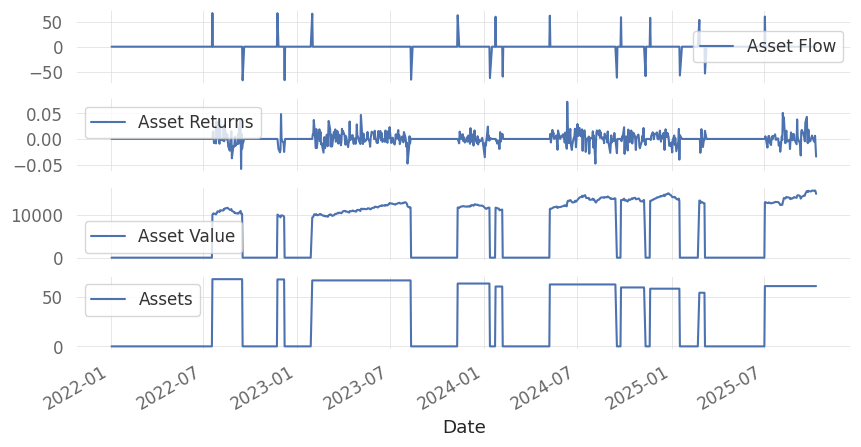

In [18]:
# timelines, related to assets
fig, axes = plt.subplots(4, 1, figsize=(10, 5), sharex=True)

pf.asset_flow().plot(ax=axes[0], label='Asset Flow', legend=True)
pf.asset_returns().plot(ax=axes[1], label='Asset Returns', legend=True)
pf.asset_value().plot(ax=axes[2], label='Asset Value', legend=True)
pf.assets().plot(ax=axes[3], label='Assets', legend=True)

<Axes: xlabel='Date'>

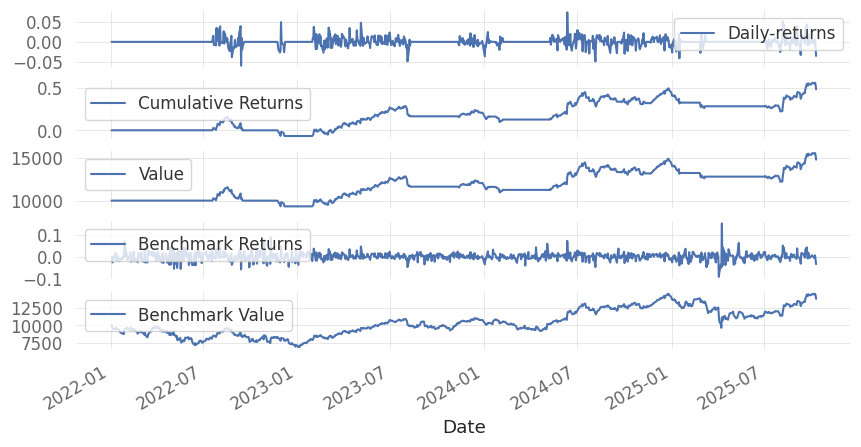

In [19]:
# timelines, related to value and returns (portfolio and benchmarks)
fig, axes = plt.subplots(5, 1, figsize=(10, 5), sharex=True)

pf.daily_returns().plot(ax=axes[0], label='Daily-returns', legend=True)
pf.cumulative_returns().plot(ax=axes[1], label='Cumulative Returns', legend=True)
pf.value().plot(ax=axes[2], label='Value', legend=True)
pf.benchmark_returns().plot(ax=axes[3],label='Benchmark Returns', legend=True)
pf.benchmark_value().plot(ax=axes[4], label='Benchmark Value', legend=True)

<Axes: xlabel='Date'>

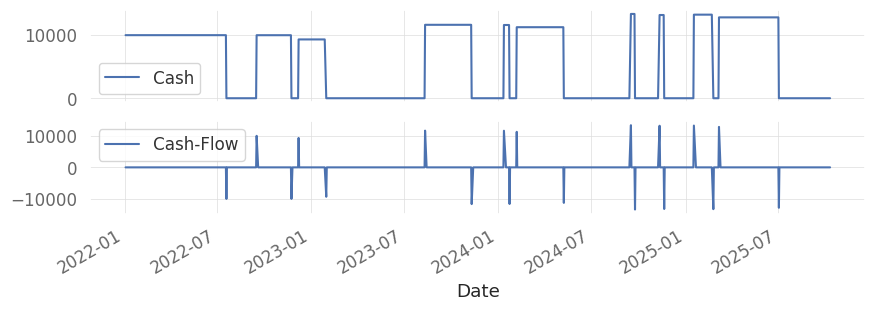

In [20]:
 # timelines, related to cash
fig, axes = plt.subplots(2, 1, figsize=(10, 3), sharex=True)

pf.cash().plot(ax=axes[0],label='Cash', legend=True)
pf.cash_flow().plot(ax=axes[1], label='Cash-Flow', legend=True)

<Axes: xlabel='Date'>

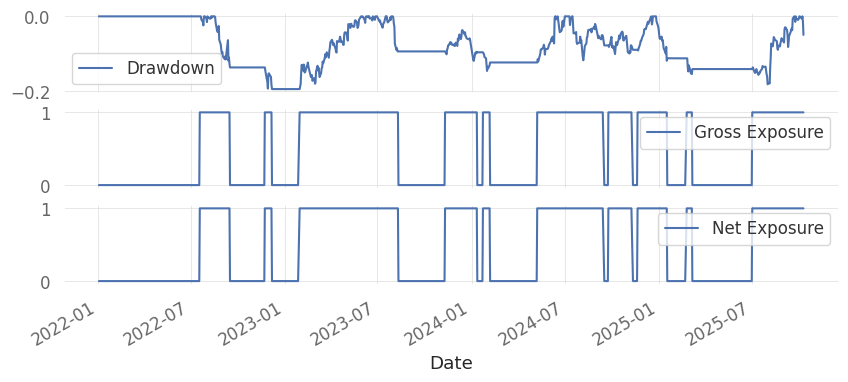

In [21]:
# Other Portfolio-related timelines
fig, axes = plt.subplots(3, 1, figsize=(10, 4), sharex=True)

pf.drawdown().plot(ax=axes[0], label='Drawdown', legend=True)
pf.gross_exposure().plot(ax=axes[1], label='Gross Exposure', legend=True)
pf.net_exposure().plot(ax=axes[2], label='Net Exposure', legend=True)

## 5.4 Methods That Return a Predefined Sub-Plot

Note: each of these subplots can be used to create customized dashboards (see Section 3.2).

In [22]:
# all available methods that genererates a sub-plot
pf.plot_asset_flow(width=1000, height=150).show()
pf.plot_asset_value(width=1000, height=150).show()
pf.plot_assets(width=1000, height=150).show()
pf.plot_cash(width=1000, height=150).show()
pf.plot_cash_flow(width=1000, height=150).show()
pf.plot_cum_returns(width=1000, height=200).show()
pf.plot_drawdowns(width=1000, height=150).show()
pf.plot_underwater(width=1000, height=150).show()
pf.plot_net_exposure(width=1000, height=150).show()
pf.plot_gross_exposure(width=1000, height=150).show()
pf.plot_orders(width=1000, height=150).show()
pf.plot_position_pnl(width=1000, height=150).show()
pf.plot_positions(width=1000, height=250).show()
pf.plot_trade_pnl(width=1000, height=150).show()
pf.plot_trades(width=1000, height=250).show()
pf.plot_value(width=1000, height=150).show()

## 6. Logging

The output methods demonstrated above provide the trader with a large amount of information to assess the implemented trading strategy. However, sometimes we need deeper insights. vbt allows enhanced logging, which stores much more detailed data about the portfolio. The logging object enables assessment of the portfolio state before and after each trade, providing additional insight into how vbt operates.

To generate a `Portfolio` instance with an extended logging object, set the parameter `log` to True when creating the portfolio:

In [ ]:
# baseline portfolio with logging
pf = vbt.Portfolio.from_signals(
    close,                  # price info (defines also the index of any timeline)
    entries,                # series (boolean) of entry-signals
    exits,                  # series (boolean) of exit-signals
    log=True,               # switch on extended logging
    init_cash=10_000,       # initial cash
    freq='D',               # all parameters on daily base
)

logs = pf.logs.records_readable

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)

Below you can find an overview of the data contained in the (extended) logging object. We can classify this information into three categories:
* Category 1: Parameters of an order and key portfolio data before the execution of the order.
* Category 2: Parameters describing the details of order execution.
* Category 3: Data of the executed order and key portfolio data after the execution of the order.

These data are available for deeper analyses of the behaviour of the `Portfolio`object.

In [ ]:
# overview about the content of the logger object
print('\n\033[1;4m*** CATEGORY 1: order parameters and portfolio data prior to order execution\033[0m')
display(logs[['Log Id', 'Column', 'Timestamp', 'Cash', 'Position', 'Debt', 'Free Cash', 'Val Price', 'Value',
              'Request Size', 'Request Price', 'Request Size Type', 'Request Direction']].head(2))

print('\n\033[1;4m*** CATEGORY 2: order parameters concering trade execution\033[0m')
display(logs[['Log Id', 'Column', 'Timestamp', 'Request Fees','Request Fixed Fees', 'Request Slippage',
              'Request Min Size','Request Max Size', 'Request Size Granularity', 'Request Rejection Prob',
              'Request Lock Cash', 'Request Allow Partial','Request Raise Rejection',
              'Request Log']].head(2))

print('\n\033[1;4m*** CATEGORY 3: portfolio data after order execution\033[0m')
display(logs[['Log Id', 'Column', 'Timestamp', 'New Cash', 'New Position', 'New Debt', 'New Free Cash',
               'New Val Price', 'New Value', 'Result Size', 'Result Price', 'Result Fees', 'Result Side',
               'Result Status', 'Result Status Info', 'Order Id']].head(2))


*** CATEGORY 1: order parameters and portfolio data prior to order execution


,Log Id,Column,Timestamp,Cash,Position,Debt,Free Cash,Val Price,Value,Request Size,Request Price,Request Size Type,Request Direction
0,0,AAPL,2022-07-19,10000.0,0.0000,0.0,10000.0,148.303482,10000.000000,inf,148.303482,Amount,Both
1,1,AAPL,2022-09-16,0.0,67.4293,0.0,0.0,148.214417,9993.994372,-67.4293,148.214417,Amount,LongOnly



*** CATEGORY 2: order parameters concering trade execution


,Log Id,Column,Timestamp,Request Fees,Request Fixed Fees,Request Slippage,Request Min Size,Request Max Size,Request Size Granularity,Request Rejection Prob,Request Lock Cash,Request Allow Partial,Request Raise Rejection,Request Log
0,0,AAPL,2022-07-19,0.0,0.0,0.0,1.000000e-08,inf,NaN,0.0,False,True,False,True
1,1,AAPL,2022-09-16,0.0,0.0,0.0,1.000000e-08,inf,NaN,0.0,False,True,False,True



*** CATEGORY 3: portfolio data after order execution


,Log Id,Column,Timestamp,New Cash,New Position,New Debt,New Free Cash,New Val Price,New Value,Result Size,Result Price,Result Fees,Result Side,Result Status,Result Status Info,Order Id
0,0,AAPL,2022-07-19,0.000000,67.4293,0.0,0.000000,148.303482,10000.000000,67.4293,148.303482,0.0,Buy,Filled,None,0
1,1,AAPL,2022-09-16,9993.994372,0.0000,0.0,9993.994372,148.214417,9993.994372,67.4293,148.214417,0.0,Sell,Filled,None,1
